# Домашнее задание 3

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [1]:
import os
import numpy as np

import math

from IPython import display

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
lr = 0.0002

b1 = 0.5
b2 = 0.999

BATCH_SIZE = 256
DATA_SIZE = BATCH_SIZE * 300

MIN_X = -25
MAX_X = 25

hidden_dim = 25

# noise random uniform min and max values
noise_min = -0.5
noise_max = 0.5

n_epochs = 500

In [4]:
y = lambda x: ((np.sin(x)/x) - (x/10))

In [5]:
x = np.linspace(MIN_X, MAX_X, 3500)

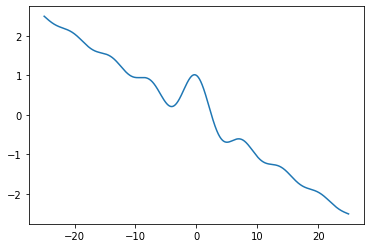

In [6]:
plt.plot(x, y(x))
plt.show;

**Сгенерируем данные для обучения**

In [7]:
x_train = np.linspace(MIN_X, MAX_X, 150500)
np.random.shuffle(x_train)
x_train = x_train[:DATA_SIZE]
y_train = y(x_train)

In [8]:
train_data = np.array([[x_train[i], y_train[i]] for i in range(x_train.shape[0])])
train_data[:10]

array([[ -8.02380747,   0.92521697],
       [-19.89199264,   2.03261549],
       [ -7.7500515 ,   0.90334031],
       [ 20.78402514,  -2.03343545],
       [ 20.02820617,  -1.95668114],
       [  1.32343072,   0.60026862],
       [-13.88065701,   1.45775126],
       [ 24.53122612,  -2.47619086],
       [ 11.19957608,  -1.20739518],
       [ 24.99867109,  -2.50521415]])

In [9]:
TRAIN_LOADER = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=12)

In [10]:
dataset_samples_count = TRAIN_LOADER.dataset.data.shape[0]
dataset_samples_count

76800

In [11]:
dataset_batches_count = math.ceil(dataset_samples_count / BATCH_SIZE)
dataset_batches_count

300

**Создадим генератор**

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(hidden_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [13]:
gen_model = Generator().double().to(device)

**Для начала сгенерируем предсказание на необученном генераторе**

In [14]:
gen_model.eval()

x = Variable(torch.from_numpy(np.random.uniform(MIN_X, MAX_X, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(x)

gen_model.train()

Generator(
  (model): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [15]:
test_pred = test_pred.cpu().detach().numpy()

In [16]:
p = test_pred[:,0].argsort()

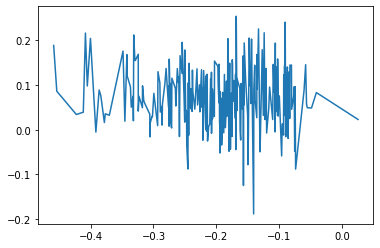

In [17]:
plt.plot(test_pred[:,0][p], test_pred[:, 1][p])
plt.show()

**Теперь создадим свои слои**

In [18]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.05, 0.05) 
        nn.init.uniform_(self.bias, -0.05, 0.05)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

**Создадим дискриминатор**

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, coords):
        coords_flat = coords.view(coords.size(0), -1)
        validity = self.model(coords_flat)

        return validity

In [20]:
discriminator_model = Discriminator().to(device)

**Теперь сгенерируем предсказание на необученном дискриминаторе**

In [21]:
discriminator_model.eval()

x = Variable(torch.from_numpy(test_pred)).to(device)

with torch.no_grad():
    test_pred2 = discriminator_model(x.float())

discriminator_model.train()

test_pred2 = test_pred2.cpu().detach().numpy()
test_pred2[:10]

array([[0.50861883],
       [0.5083884 ],
       [0.5083015 ],
       [0.5085675 ],
       [0.50852114],
       [0.5085678 ],
       [0.50841665],
       [0.50839317],
       [0.5084498 ],
       [0.5080782 ]], dtype=float32)

**Выполним тренировку. Процесс не быстрый**

In [22]:
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

[Epoch 500/500] [D loss: 0.693139] [G loss: 0.693158]


<Figure size 432x288 with 0 Axes>

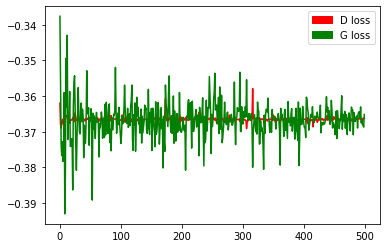

CPU times: user 27min 34s, sys: 6min 58s, total: 34min 33s
Wall time: 37min 40s


In [23]:
%%time

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    
    generator_epoch_loss = 0.0
    discriminator_epoch_loss = 0.0
    
    for i, data in enumerate(TRAIN_LOADER):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0), requires_grad=False).to(device)
        
        real_coords = Variable(data.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################
        
        optimizer_G.zero_grad()
    
        z = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

        gen_coords = gen_model(z)

        validity = discriminator_model(gen_coords.float())
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        generator_epoch_loss += g_loss.item()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator_model(real_coords.float())
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator_model(gen_coords.detach().float())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        discriminator_epoch_loss += d_loss.item()

######## Отображение процесса обучения и вывод функций потерь ############
        if (i+1) % dataset_batches_count == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"% (epoch+1, n_epochs, discriminator_epoch_loss / dataset_batches_count, generator_epoch_loss / dataset_batches_count)) 

            
            display.display(plt.gcf())
            
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show();

**Выполним проверку модели во всем диапазоне данных**

In [24]:
gen_model.eval()

xx = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(xx)

gen_model.train()

test_pred = test_pred.cpu().detach().numpy()

In [25]:
count = 0
error = 0.0
for i in range(len(test_pred)):
    xxx = test_pred[i][0]
    y_pred = test_pred[i][1]
    y_real = y(xxx)
    print("X: %.10f;\t" % xxx, "y_pred: %.10f;\t\t" % y_pred, "y_real: %.10f" % y_real)
    
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))

X: -18.8687055864;	 y_pred: 1.9059092339;		 y_real: 1.8878853868
X: -3.8970199572;	 y_pred: 0.2135711405;		 y_real: 0.2137727455
X: 13.6352780320;	 y_pred: -1.5578175742;		 y_real: -1.2992331549
X: 8.7957695977;	 y_pred: -0.8481628348;		 y_real: -0.8126876226
X: -1.2217244923;	 y_pred: 0.7743896074;		 y_real: 0.8913234158
X: 13.7575787001;	 y_pred: -1.5672430115;		 y_real: -1.3082447337
X: 7.4131612153;	 y_pred: -0.6990124618;		 y_real: -0.6193166285
X: -12.1384761563;	 y_pred: 1.2437400487;		 y_real: 1.1796624338
X: -2.6928893090;	 y_pred: 0.3693023943;		 y_real: 0.4303789533
X: -8.2316423218;	 y_pred: 0.8971990823;		 y_real: 0.9360857801
X: 20.4127554024;	 y_pred: -2.2356256461;		 y_real: -1.9922879771
X: -23.3221673367;	 y_pred: 2.4253065471;		 y_real: 2.2905657666
X: 9.1824371972;	 y_pred: -0.9101351525;		 y_real: -0.8921095202
X: 14.1767861406;	 y_pred: -1.6114625267;		 y_real: -1.3471961188
X: -13.3008068666;	 y_pred: 1.4069317494;		 y_real: 1.3804662648
X: 0.2527299829;	 y_pred:

**Построим график**

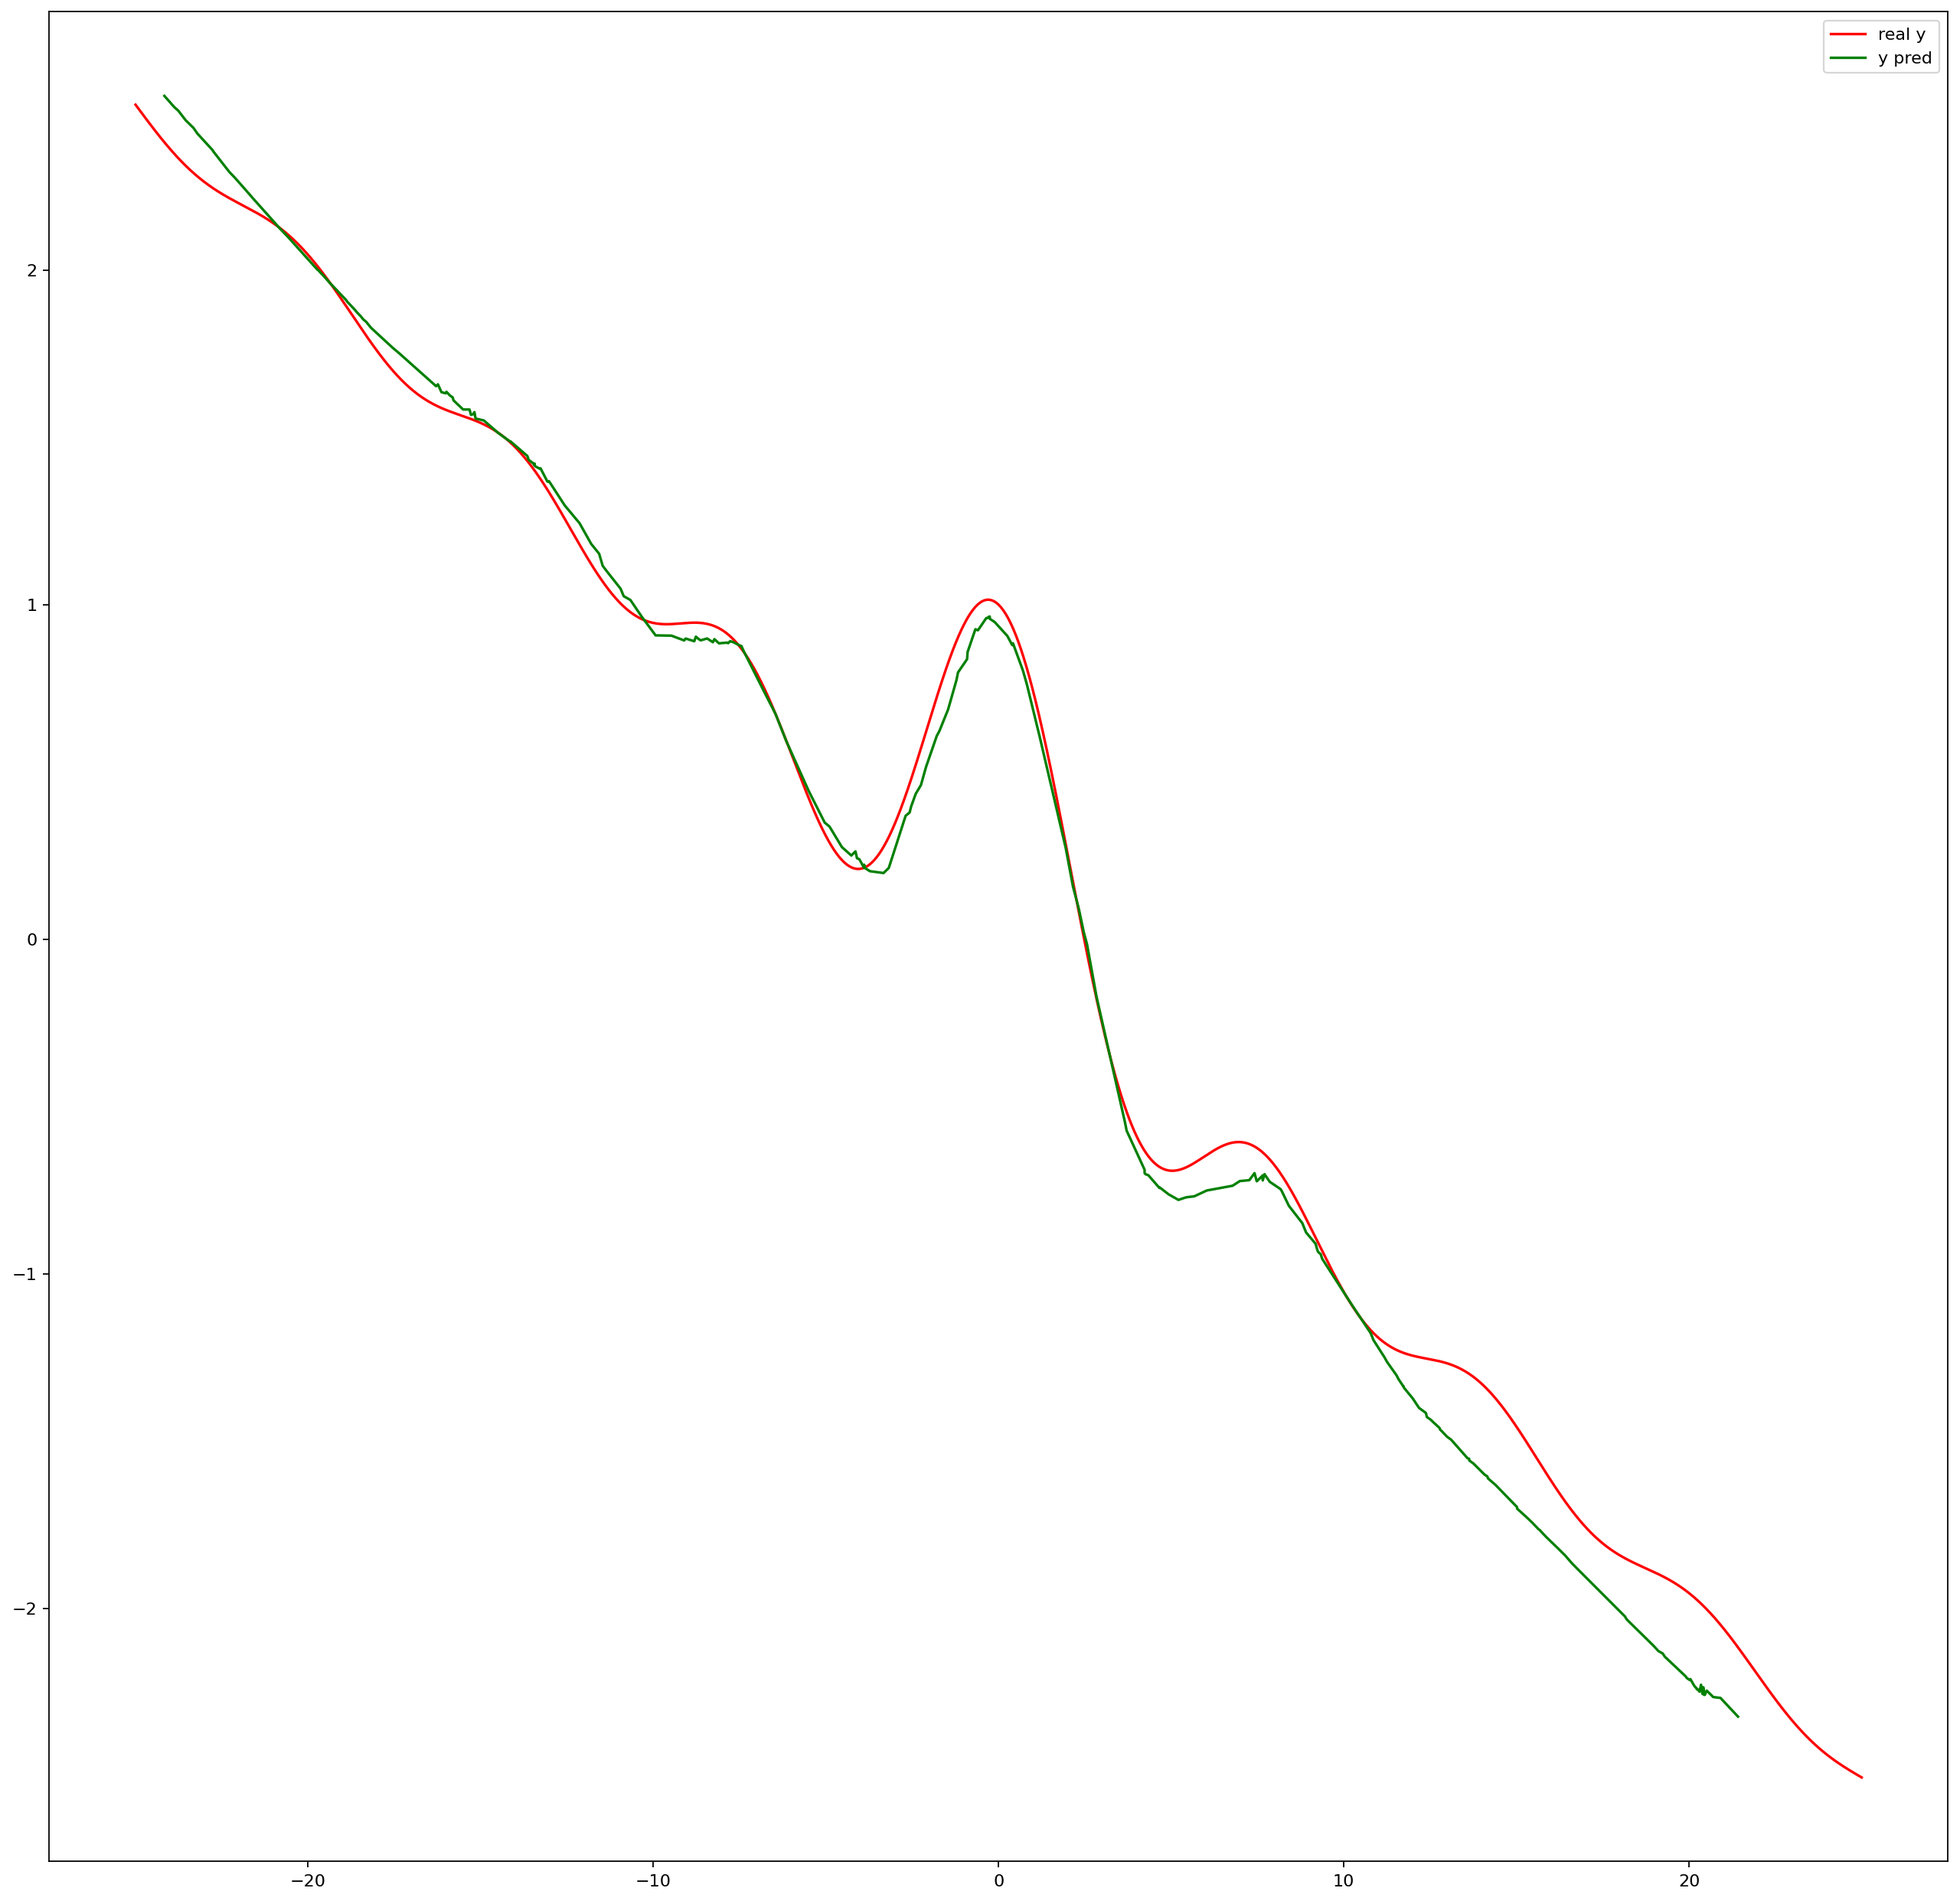

In [26]:
figure(num=None, figsize=(20, 20), dpi=160)

real_x = np.linspace(MIN_X, MAX_X, 3500)
plt.plot(real_x, y(real_x), label='real y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()

**Вывод:** за 500 эпох модели удалось научиться достаточно неплохо иммитировать данные математической зависимости